In [1]:
import numpy as np 
import torch 
import pandas as pd
import yfinance as yf
from arch import arch_model
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from scipy.optimize import minimize
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import pytorch_lightning as pl
import json
import os 
from datetime import datetime

In [2]:
if (torch.cuda.is_available()):
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [ ]:
#Нужна формула разложения оператора в ряд тейлора до заданного наперед члена (это и будет T-1) а как сделать backprop? (м.б. нужно свернуть все обратно как то, у нас же будет итоговая формула)

In [ ]:
def compute_lambdas (omega, beta, phi, d , truncation_size):
    

In [49]:
def generate_ground_gjrgarch(omega, alpha,gamma, beta, n=1000):
    
    am = arch_model(None, mean='Zero', vol='GARCH', p=1, o=1, q=1, power = 2) #Остатки просто получаются умножением волатильности на кси ~N(0,1)
    params = np.array([omega, alpha, gamma, beta])
    am_data = am.simulate(params, n)

    return am_data['data'].to_numpy(), am_data['volatility'].to_numpy()

In [50]:
omega, alpha, gamma, beta = 0.2, 0.2, 0.05,  0.75 # Ограничения на параметры - α + γ/2 + β < 1, α + γ ≥ 0
scale = 100

In [51]:
data, volat = generate_ground_gjrgarch(omega,alpha,gamma, beta)


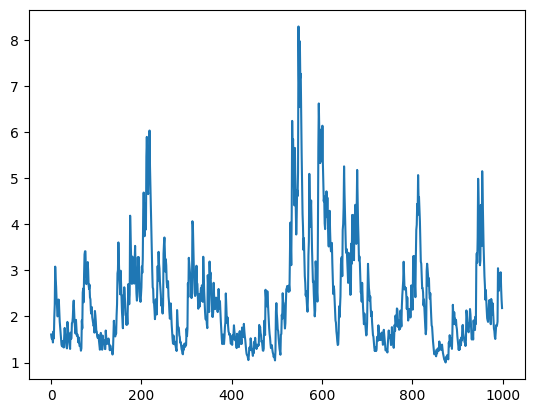

In [52]:
plt.plot(np.arange(1000), volat)

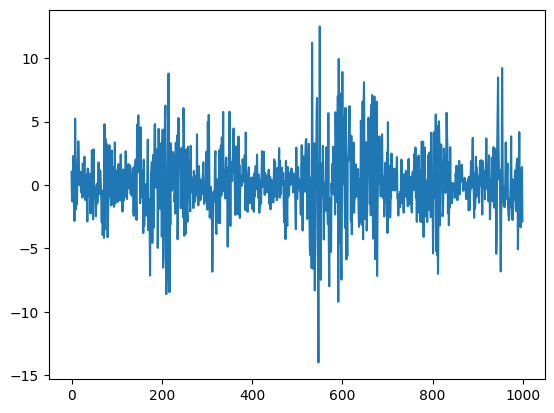

In [53]:
plt.plot(np.arange(1000), data)

In [54]:
class CustomSyntDataset(Dataset):
    def __init__(self, omega, alpha, gamma, beta, n=100000, scale=scale):
        self.scale = scale
        self.residuals, self.volatility = generate_ground_gjrgarch(omega, alpha, gamma, beta, n)
        

        residuals_scaled = self.residuals * scale
        volatility_scaled = self.volatility * scale 
        

        self.inputs = np.column_stack([
            np.full(n, scale**2),  
            np.square(residuals_scaled),
            np.where(residuals_scaled < 0,1,0) * np.square(residuals_scaled),
            np.square(volatility_scaled)
        ])
        

        self.outputs = np.square(volatility_scaled)
        

        self.next_eps_squared = np.square(residuals_scaled) 
        
        self.inputs = torch.FloatTensor(self.inputs[:-1]).to(device)
        self.outputs = torch.FloatTensor(self.outputs[1:]).to(device)
        self.next_eps_squared = torch.FloatTensor(self.next_eps_squared[1:]).to(device)

    def __len__(self):
        return len(self.inputs)  
    
    def __getitem__(self, index):
        return (
            self.inputs[index], 
            self.outputs[index],    
            self.next_eps_squared[index] 
        )

In [55]:
ds = CustomSyntDataset(omega=omega, alpha=alpha,gamma=gamma, beta = beta)

In [56]:
for i in range(1, 5):
    print(ds[i])

(tensor([10000.0000,  2972.8735,  2972.8735, 22178.8887], device='cuda:0'), tensor(19377.3848, device='cuda:0'), tensor(3161.9243, device='cuda:0'))
(tensor([10000.0000,  3161.9243,     0.0000, 19377.3848], device='cuda:0'), tensor(17165.4238, device='cuda:0'), tensor(10430.8145, device='cuda:0'))
(tensor([10000.0000, 10430.8145,     0.0000, 17165.4238], device='cuda:0'), tensor(16960.2305, device='cuda:0'), tensor(576.0275, device='cuda:0'))
(tensor([10000.0000,   576.0275,   576.0275, 16960.2305], device='cuda:0'), tensor(14864.1797, device='cuda:0'), tensor(16110.8936, device='cuda:0'))


In [57]:
dl = DataLoader(ds, batch_size = 1024, shuffle= False, drop_last=False)

In [58]:
class GarchNN(torch.nn.Module):
    def __init__(self, init_omega=0.05, init_alpha=0.1, init_gamma = 0.15 , init_beta=0.7):
        super(GarchNN, self).__init__()
        self.model =nn.Sequential(
            nn.Linear(4,1, bias=False)
        )
        self._initialize_weights(init_omega, init_alpha, init_gamma, init_beta)

    def _initialize_weights(self, omega, alpha, gamma, beta):

        init_weights = torch.tensor([omega, alpha, gamma, beta], dtype=torch.float32)
        
        with torch.no_grad():
            self.model[0].weight.copy_(init_weights.unsqueeze(0))

    def forward (self, x):
        return self.model(x).squeeze(-1)

In [59]:
class EarlyStopping:
    def __init__(self, patience=30, delta=0.00005, verbose=True):
        self.patience = patience
        self.delta = delta
        self.verbose = verbose
        self.counter = 0
        self.best_loss = float('inf')
        self.early_stop = False

    def __call__(self, val_loss, model):
        if val_loss < self.best_loss - self.delta:
            self.best_loss = val_loss
            self.counter = 0

            self.best_weights = model.state_dict().copy()
        else:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter}/{self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
                if self.verbose:
                    print("Early stopping triggered")

In [60]:
class CorrectedNLoss(nn.Module):
    def __init__(self, scale=1):
        super().__init__()
        self.scale = scale ** 2
        self.offset = torch.log(torch.tensor(scale**2)).item()
    def forward(self, pred_var, target_eps_squared):

        
        
        loss =  (0.5*(torch.log(pred_var)) + (target_eps_squared/(2*pred_var))) 
        return loss.mean()

In [61]:
ground_truth = (omega, alpha, gamma, beta)

In [62]:
model = GarchNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr =1e-3)
criterion = CorrectedNLoss()
#criterion = nn.MSELoss()
early_stopping = EarlyStopping(patience=30, verbose=True)

In [63]:
def save_results(model_params, ground_truth, filename='gjrgarch_results.json'):
    # Подготовка данных
    result = {
        'timestamp': datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
        'ground_truth': {
            'omega': float(ground_truth[0]),
            'alpha': float(ground_truth[1]),
            'gamma' : float(ground_truth[2]),
            'beta': float(ground_truth[3]),
        },
        'model_params': {
            'omega': float(model_params[0]),
            'alpha': float(model_params[1]),
            'gamma' : float(model_params[2]),
            'beta': float(model_params[3])
        }

    }
    
    # Запись в файл (дозапись)
    mode = 'a' if os.path.exists(filename) else 'w'
    with open(filename, mode, encoding='utf-8') as f:
        f.write(json.dumps(result, indent=4) + '\n')  # Добавляем перевод строки

In [64]:
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 
    mode='min',
    factor=0.5, 
    patience=5,
    min_lr= 1e-6
)

In [65]:
num_epochs = 500

for epochs in tqdm(range(num_epochs), desc="Training"):
    epoch_loss =0.0
    model.train()

    for inputs, targets, resids in dl:
        optimizer.zero_grad()
        output = model(inputs)
        loss = criterion(output, resids)
        loss.backward()
        optimizer.step()
        
        epoch_loss+=loss.item()

    avg_loss = epoch_loss/len(dl)

    scheduler.step(avg_loss)

    early_stopping(avg_loss, model)
    if early_stopping.early_stop:
        break
    
    tqdm.write(f"Epoch {epochs+1}/{num_epochs} | Loss: {avg_loss:.4f} | LR: {optimizer.param_groups[0]['lr']:.2e}")

model.load_state_dict(early_stopping.best_weights)



Training:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 1/500 | Loss: 5.8211 | LR: 1.00e-03
Epoch 2/500 | Loss: 5.8188 | LR: 1.00e-03
Epoch 3/500 | Loss: 5.8185 | LR: 1.00e-03
Epoch 4/500 | Loss: 5.8184 | LR: 1.00e-03
EarlyStopping counter: 1/30
Epoch 5/500 | Loss: 5.8184 | LR: 1.00e-03
EarlyStopping counter: 2/30
Epoch 6/500 | Loss: 5.8184 | LR: 1.00e-03
EarlyStopping counter: 3/30
Epoch 7/500 | Loss: 5.8184 | LR: 1.00e-03
EarlyStopping counter: 4/30
Epoch 8/500 | Loss: 5.8184 | LR: 5.00e-04
Epoch 9/500 | Loss: 5.8184 | LR: 5.00e-04
EarlyStopping counter: 1/30
Epoch 10/500 | Loss: 5.8184 | LR: 5.00e-04
EarlyStopping counter: 2/30
Epoch 11/500 | Loss: 5.8184 | LR: 5.00e-04
EarlyStopping counter: 3/30
Epoch 12/500 | Loss: 5.8184 | LR: 5.00e-04
EarlyStopping counter: 4/30
Epoch 13/500 | Loss: 5.8184 | LR: 5.00e-04
EarlyStopping counter: 5/30
Epoch 14/500 | Loss: 5.8184 | LR: 2.50e-04
EarlyStopping counter: 6/30
Epoch 15/500 | Loss: 5.8183 | LR: 2.50e-04
EarlyStopping counter: 7/30
Epoch 16/500 | Loss: 5.8183 | LR: 2.50e-04
EarlyStopping

<All keys matched successfully>

In [66]:

weights = model.model[0].weight.detach().cpu().numpy()[0]
model_params = (
    weights[0],  
    weights[1],
    weights[2],
    weights[3]
)
save_results(model_params, ground_truth)

    

In [67]:
print(torch.isnan(ds.inputs).any(), torch.isinf(ds.inputs).any())
print(torch.isnan(ds.outputs).any(), torch.isinf(ds.outputs).any())

tensor(False, device='cuda:0') tensor(False, device='cuda:0')
tensor(False, device='cuda:0') tensor(False, device='cuda:0')


In [68]:
def get_model_weights(model, scale = scale):
    weights = {}
    for name, param in model.named_parameters():
        weights[name] = param.data.clone().cpu().numpy()
    return weights

model_weights = get_model_weights(model)

In [69]:
model_weights 

{'model.0.weight': array([[0.18770337, 0.19816369, 0.03682585, 0.7534921 ]], dtype=float32)}